# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>Physical modelling</b> 

<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
%matplotlib inline
import ipywidgets as widgets

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import signal
import import_ipynb
from Helpers import * 
import matplotlib
from IPython.display import IFrame

figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16})

fs=44100;

importing Jupyter notebook from Helpers.ipynb


## 1. Karplus–Strong string synthesis

A rather easy model for synthesizing a string was proposed in 1983 in the article "Digital Synthesis of Plucked String and Drum Timbres" by Karplus and Strong. It defines the string as being a very short noise generator followed by a lowpass loop. The delay of the loop determines the frequency of the string, and the length of the noise burst the "precision" of the picking of the string. Hence, a short noise burst would generate a rather "striked string" sound, corresponding to instruments such as the harpsicord, while longer noise burst would create a more "bowed string" sound, such as a violin.

The diagram is as follows

<img src="pictures/strong.png" alt="Drawing" style="width: 60%;"/>

where the lowpass filter is typically implement using a simple moving average over the past samples. The size of the moving average influences the dampening of the string over time.

The value $N$ (in samples) of the delay is simply calculated by (euclidean) dividing the sampling frequency $f_s$ by the desired string frequency $f$,
$$
N = \lfloor fs /f \rfloor .
$$

Let's implement it!

In [29]:
def karplus_strong(freq, pinch=.02, sustain=.99, dampen=2, duration=2, lowpass=False):
    """
    Plays a string sound using the Karplus-Strong model.
    freq: the frequency (in hertz) of the played string
    pinch: the length (in seconds) of the initial pinching of the string
    sustain: the sustain factor of the vibration of the string after the pinching (1 is normal sustain)
    dampen: the level of dampening of the string (1 = no dampen, higher int values is more dampen)
    duration: the duration of the output sound in seconds
    lowpass: apply a lowpass to the output signal
    returns: a numpy array containing the vibrating string's data
    """
    out = np.zeros(duration*fs) # placeholder for the output
    burst = 2*np.random.random(int(pinch*fs)) - 1 # Random noise in [-1, 1] lasting pinch ms
    out[:int(pinch*fs)] = burst # output starts with burst
    
    delay = fs//freq # delay of the loop (in samples)
    for i in range(delay, duration*fs): # delay loop
        out[i] += sustain * np.mean(out[i-delay:i-delay+dampen])
        
    if lowpass: out = butter_pass_filter(out, np.array([int(10*freq)]), fs, "low", order=1)
    return normalize(out)

Let's test it with a 200Hz frequency.

string = karplus_strong(150, lowpass=True)

Audio(string, rate=fs)

Sounds quite synthetic, but given the simplycity of the code above, this is already quite good! Let's have a look at the frequencies and try playing with them.

In [4]:
@widgets.interact(freq=(50, 500, 50), pinch=(0.1, 0.5, 0.1), sustain=(.98, 1, 0.001), damper=(1, 10, 1))
def update(freq=200, pinch=.02, sustain=.99, damper=2,):
    
    test = karplus_strong(freq, pinch, sustain, damper, duration=2)

    plt.figure(figsize=figsize)
    plt.plot(test)
    plt.xlabel("Time [samples]")
    plt.show()

    plt.figure(figsize=figsize)
    plt.magnitude_spectrum(test)
    plt.xlim(0, .3)
    plt.show()

interactive(children=(IntSlider(value=200, description='freq', max=500, min=50, step=50), FloatSlider(value=0.…

The frequency spectrum is quite rich already. Try playing with the sliders and observe how each parameter influences the spectrum.

## 2. Snare model

In [145]:
%%capture
from Synthesizer import sine, triangle

In [323]:
my_sine = sine(1, 180*2*np.pi, 0, np.linspace(0, .1, int(fs/10)))
Audio(my_sine, rate=fs)

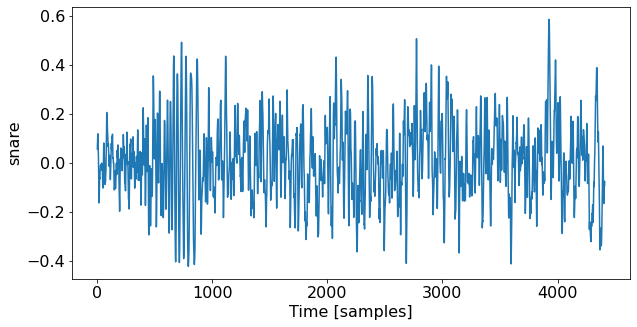

In [505]:
length = int(fs/10)

noise = 2*np.random.random(length) - 1

crack = noise.copy()
crack[:int(.2*length)] = signal.chirp(t=np.linspace(0, 1/4, int(.2*length)), f0=1000, t1=.08, f1=400, method="logarithmic")


filt = butter_pass_filter(np.mean((crack,noise), axis=0), np.array([1500]), fs, "low", order=2)

resonance = signal.chirp(t=np.linspace(0, 1/4, length), f0=400, t1=.2, f1=375, method="logarithmic")

snare = 0.05*resonance + filt

plt.figure(figsize=figsize)
plt.plot(snare)
plt.xlabel("Time [samples]")
plt.ylabel("snare")
plt.show()

Audio(snare, rate=fs)

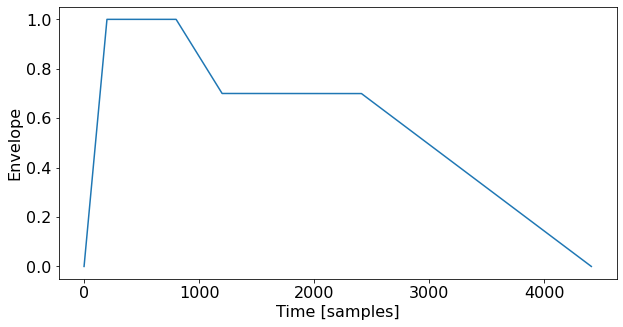

In [516]:
envelope = np.ones(noise.size) * 0.7
envelope[:200] = np.linspace(0,1,200)
envelope[200:800] = 1
envelope[800:1200] = np.linspace(1,.7, 400)
envelope[-2000:] = np.linspace(0.7, 0, 2000)

plt.figure(figsize=figsize)
plt.plot(envelope)
plt.xlabel("Time [samples]")
plt.ylabel("Envelope")
plt.show()

Audio(snare*envelope + .1*kick[:snare.size], rate=fs)

## 3. Kick

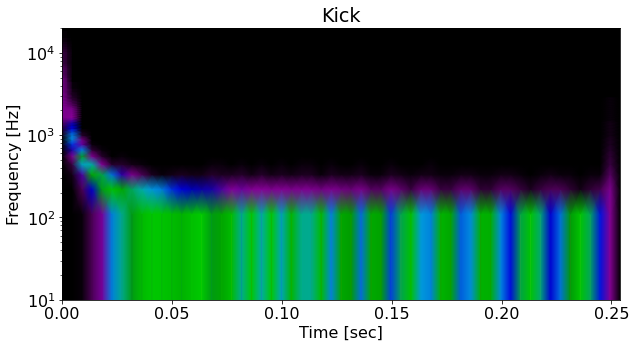

In [510]:
t = np.linspace(0, 1/4, int(fs/4))
sweep = signal.chirp(t, f0=14000, t1=.25, f1=20, method="hyperbolic")

# Plot
f, t, Zxx = signal.stft(sweep, fs, nperseg=400)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='nipy_spectral', shading='gouraud')
plt.title("Kick")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(10, 20000)
plt.yscale("log")
#plt.savefig("speech_STFT.png", dpi=150, bbox_inches='tight')
plt.show()

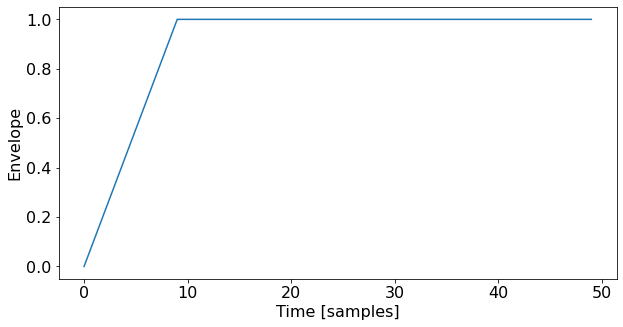

In [511]:
envelope = np.ones(sweep.size)
envelope[:10] = np.linspace(0,1,10)
envelope[-1000:] = np.linspace(1,0,1000)

plt.figure(figsize=figsize)
plt.plot(envelope[:50])
plt.xlabel("Time [samples]")
plt.ylabel("Envelope")
plt.show()

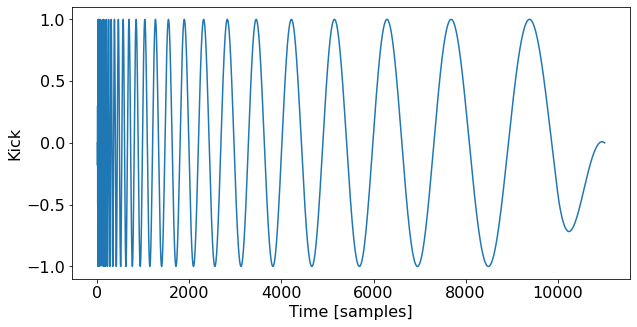

In [512]:
kick = sweep * envelope

plt.figure(figsize=figsize)
plt.plot(kick)
plt.xlabel("Time [samples]")
plt.ylabel("Kick")
plt.show()

Audio(kick, rate=fs)

## 4. Hats

In [390]:
noise1 = 2*np.random.random(int(fs/15)) - 1
noise2 = 2*np.random.random(int(fs/15)) - 1
noise1 = butter_pass_filter(noise1, np.array([8000]), fs, "high", order=5)
noise2 = butter_pass_filter(noise2, np.array([6000, 6500]), fs, "band", order=5)

In [389]:
Audio(noise1+noise2, rate=fs)